In [1]:
! pip install -r requirements.txt



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


from wordcloud import WordCloud, STOPWORDS
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV



In [3]:
import spacy
print(spacy.__version__)

3.8.4


In [4]:
# import spacy
# nlp = spacy.load("en_core_web_sm")
# text = "SpaCy is an amazing NLP library!"
# doc = nlp(text)
# print("Tokens:", [token.text for token in doc])
# print("Named Entities:", [(ent.text, ent.label_) for ent in doc.ents])


### Basic EDA

In [5]:
def data_info(data_path):
    df=pd.read_csv(data_path)
    print('\nData head:')
    print(df.head(5))
    print('\nData Summary:')
    print(df.info())
    print('\nData Shape:')
    print(df.shape)
    return df

In [6]:
train_data = data_info('data/train.csv')
test_data= data_info('data/test.csv')


Data head:
        id                                               text author
0  id26305  This process, however, afforded me no means of...    EAP
1  id17569  It never once occurred to me that the fumbling...    HPL
2  id11008  In his left hand was a gold snuff box, from wh...    EAP
3  id27763  How lovely is spring As we looked from Windsor...    MWS
4  id12958  Finding nothing else, not even gold, the Super...    HPL

Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB
None

Data Shape:
(19579, 3)

Data head:
        id                                               text
0  id02310  Still, as I urged our leaving Ireland with suc...
1  id24541  If a fire wanted fanning, it could readily be ...
2 

In [7]:
print(f'Unique CLasses: {train_data["author"].unique()}' )

Unique CLasses: ['EAP' 'HPL' 'MWS']


<BarContainer object of 3 artists>

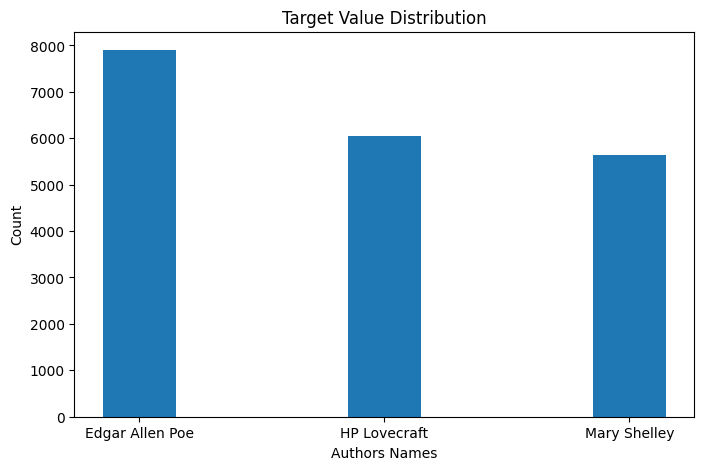

In [8]:
classes={'EAP':'Edgar Allen Poe','HPL':'HP Lovecraft','MWS':'Mary Shelley'}

plt.figure(figsize=(8,5))
x = train_data.author.map(classes).unique()
y = train_data.author.value_counts().values
plt.title('Target Value Distribution')
plt.xlabel('Authors Names')
plt.ylabel('Count')
plt.bar(x,y,width=0.3)

Text(0.5, 1.0, 'Top 100 Word Frequencies in the Training Dataset')

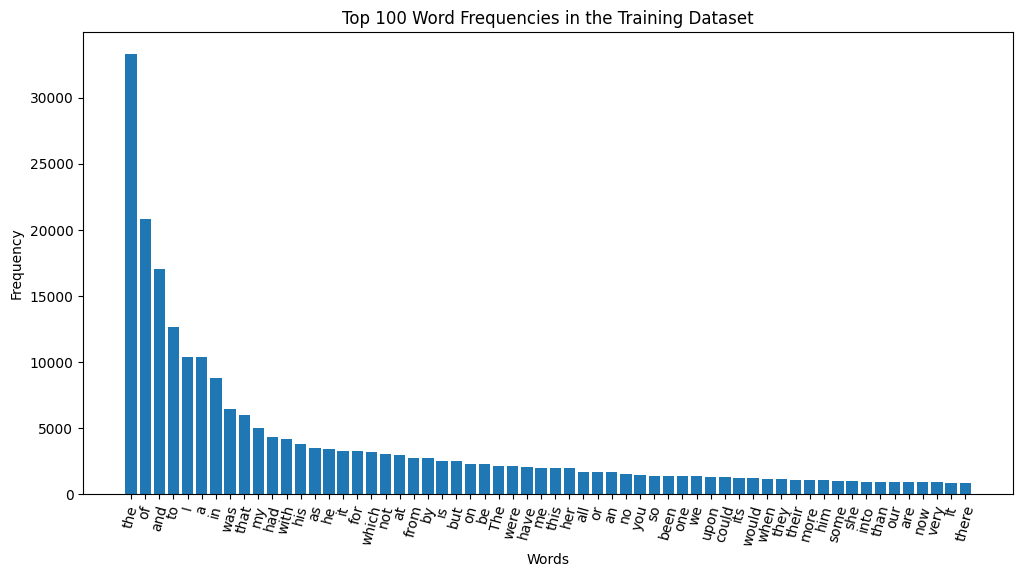

In [9]:
all_words=train_data['text'].str.split(expand=True).unstack().value_counts()
top_words = all_words.iloc[0:60]
plt.figure(figsize=(12, 6))
plt.bar(top_words.index, top_words.values)
plt.xticks(rotation=75)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 100 Word Frequencies in the Training Dataset")

In [10]:
top_words.iloc[0:5]

the    33296
of     20851
and    17059
to     12615
I      10382
Name: count, dtype: int64

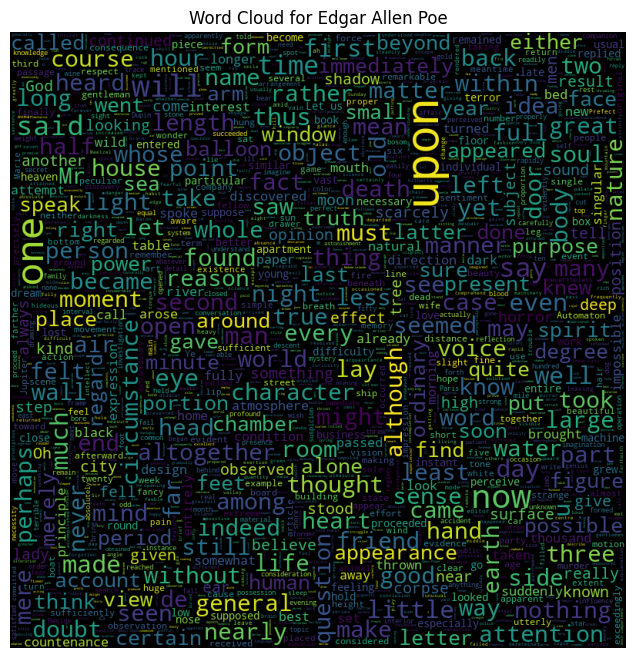

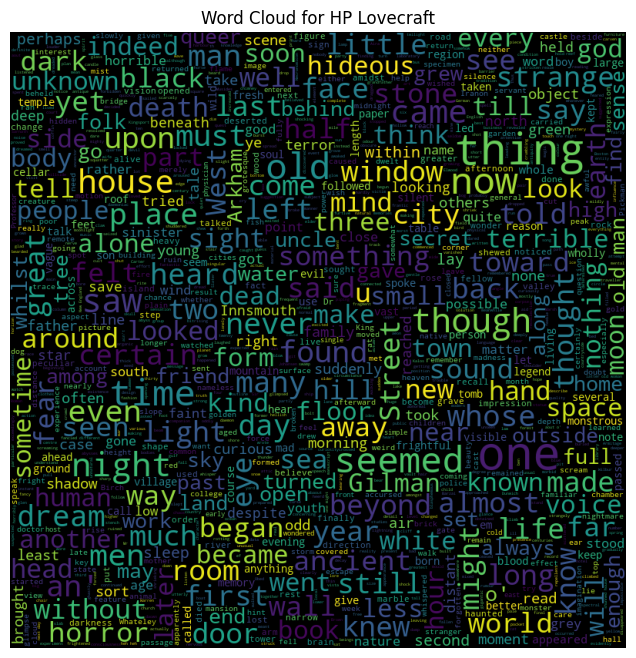

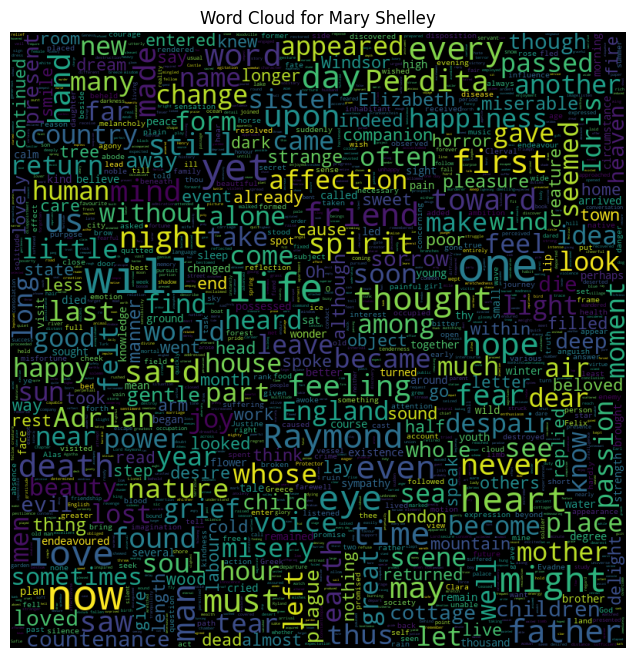

In [11]:
#plotting most frequent words that are unique to each class excluding common words
def plot_word_cloud(author):
    text = train_data[train_data.author==author].text.str.cat(sep=' ')
    wordcloud = WordCloud(width=800,height=800,background_color ='black',max_words=7000,stopwords = STOPWORDS,max_font_size=60).generate(text)
    plt.figure(figsize=(8,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Word Cloud for {classes[author]}")
    plt.show()

for i in classes.keys():
    plot_word_cloud(i)

### Text Preprocessing
1. tokenization
2. stopwords removal
3. lemmatization
4. vectorization

In [12]:
spacy_process = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 

#removing single characters, digits and punctuations
pattern = re.compile(r'\b([a-zA-Z])\b|\d+|[.,!?()-:;]')
stop_words = set(stopwords.words('english')) 

In [13]:
def process_text(text):
    
    text = pattern.sub(' ', text.lower())
    lemmas=spacy_process(text)
    lemmas = [token.lemma_ for token in lemmas if token.lemma_ not in stop_words]
    text=' '.join(lemmas)
    return text

def process_dataset(train_data, test_data):
    
    vectorizer=TfidfVectorizer(sublinear_tf = True,stop_words='english',ngram_range=(1,3))
    svd = TruncatedSVD(n_components=100)
    scaler = StandardScaler(with_mean = False)
    
    X_train_tfidf = vectorizer.fit_transform(train_data)
    X_test_tfidf = vectorizer.transform(test_data)

    X_train_svd = svd.fit_transform(X_train_tfidf)
    X_test_svd = svd.transform(X_test_tfidf)

    X_train_stand_svd = scaler.fit_transform(X_train_svd)
    X_test_stand_svd = scaler.transform(X_test_svd)
    
    return X_train_stand_svd, X_test_stand_svd


In [14]:
train_data['text'] = train_data['text'].apply(process_text)
test_data['text'] = train_data['text'].apply(process_text)

In [15]:
X_train, X_test = process_dataset(train_data['text'], test_data['text'])

In [16]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(train_data['author'])
print(y_train)



[0 1 0 ... 0 0 1]


### Training ML models

In [17]:
def train_ml_models(X_train,y_train):
    
    models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5,criterion='gini'),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, max_depth=5,objective='multi:softprob'),
    "SVM": SVC(kernel='rbf')
    }
    
    train_accuracies={}
    best_model=None
    model_names = list(models.keys())

    print("Training Models with 3-fold Cross Validation \n")
    for name, model in models.items():
        train_accuracy = np.mean(cross_val_score(model, X_train, y_train, cv=3))
        
        train_accuracies[model]=train_accuracy
        
        print(f"{name}: Training Accuracy = {train_accuracy:.3f}")
        
    best_model = max(train_accuracies, key=train_accuracies.get)
    
    return best_model


In [18]:
best_model = train_ml_models(X_train,y_train)

Training Models with 3-fold Cross Validation 



Logistic Regression: Training Accuracy = 0.652
Random Forest: Training Accuracy = 0.581
XGBoost: Training Accuracy = 0.661
SVM: Training Accuracy = 0.674


In [19]:
def train_hyperparam_tuning(X_train, y_train):
    warnings.filterwarnings("ignore")
    param_grid = {
        'C': [1, 10], 
        'gamma': [1, 0.1], 
        'kernel': ['rbf', 'poly']
    }
    
    grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, scoring='neg_log_loss', return_train_score=True)
    grid.fit(X_train, y_train)

    results_df = pd.DataFrame(grid.cv_results_)
    results_df = results_df[['param_C', 'param_gamma', 'param_kernel', 
                             'mean_fit_time', 'mean_score_time', 
                             'mean_train_score', 'mean_test_score']]
    
    # Convert negative log loss to positive for readability
    results_df['mean_train_score'] = -results_df['mean_train_score']
    results_df['mean_test_score'] = -results_df['mean_test_score']


    results_df = results_df.sort_values(by='mean_test_score')

    print(f"Best Parameters: {grid.best_params_}")
    print("\nFull Grid Search Results:")
    print(results_df)

    return grid.best_estimator_, grid.best_params_


In [20]:
#inference on test data
best_model,best_params=train_hyperparam_tuning(X_train,y_train)
y_pred_test = best_model.predict(X_test)
y_pred_test = encoder.inverse_transform(y_pred_test)
test_data['author'] = y_pred_test
test_data.head(5)



Fitting 5 folds for each of 8 candidates, totalling 40 fits


[CV 1/5] END C=1, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time= 2.2min
[CV 2/5] END C=1, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time= 2.2min
[CV 3/5] END C=1, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=  35.8s
[CV 4/5] END C=1, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=  29.2s
[CV 5/5] END C=1, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=  30.3s
[CV 1/5] END C=1, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=  26.8s
[CV 2/5] END C=1, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=  26.6s
[CV 3/5] END C=1, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=  30.4s
[CV 4/5] END C=1, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=  30.7s
[CV 5/5] END C=1, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=  31.6s
[CV 1/5] END C=1, gamma=0.1, kernel=rbf;, score=(train=nan, test=nan) total time=  24.7s
[CV 2/5] END C=1, gamma=0.1, kernel=

,id,text,author
0,id02310,process however afford mean ascertain...,EAP
1,id24541,never occur fumbling might mere mistake,HPL
2,id00134,leave hand gold snuff box caper hill ...,EAP
3,id27757,lovely spring look windsor terrace sixteen fer...,MWS
4,id04081,find nothing else even gold superintende...,HPL
